# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [1]:
import random
import numpy as np
import tensorflow as tf
import os

# Set random seeds for reproducibility
random.seed(42)          # Python's random module
np.random.seed(42)       # NumPy (used by scikit-learn)
tf.random.set_seed(42)   # TensorFlow/Keras
os.environ['PYTHONHASHSEED'] = str(42)

In [2]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from medpy.filter.smoothing import anisotropic_diffusion as ani_diff
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import seaborn as sns
import cv2
import imutils
import matplotlib.pyplot as plt
import time
from os import listdir
from tqdm import tqdm
import matplotlib.image as mpimg


%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [3]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if not cnts:
        print("No contours found in image")
        return image

    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

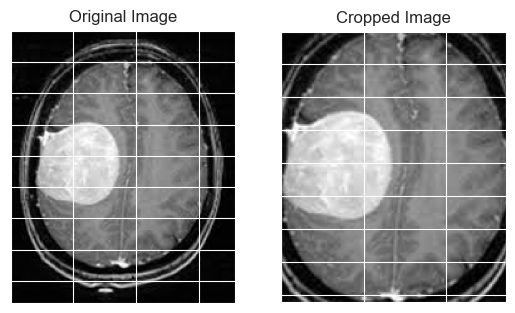

In [4]:
ex_img = cv2.imread('../../yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [5]:
def load_data(dir_list,
              image_size,
              grayscale,
              contrast_enhancement,
              anisotropic_diffusion,
              smoothing,
              bilateral_filtering,
              clip_limit=3.0,
              tile_grid_size=8,
              kernel_size=7,
              d = 5,
              sigma_color = 30,
              sigma_space = 30,
              aniso_niter = 10,
              aniso_kappa = 50,
              aniso_gamma = 0.1,
              aniso_option = 1):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)

            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)

            if grayscale:
                if len(image.shape) == 3:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # normalize values
            image = image / 255.

            if smoothing:
                    # Create averaging kernel
                    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size**2)

                    for i in range(3):
                        image[:,:,i] = cv2.filter2D(image[:,:,i], -1, kernel)

            if bilateral_filtering:
                # Convert to uint8 for bilateral filter (it requires uint8)
                image_uint8 = (image * 255).astype(np.uint8)

                filtered = np.zeros_like(image_uint8)
                for i in range(3):
                    filtered[:,:,i] = cv2.bilateralFilter(image_uint8[:,:,i], d, sigma_color, sigma_space)
                image = filtered.astype(np.float32) / 255.0

            if anisotropic_diffusion:
                for i in range(3):
                    image[:,:,i] = ani_diff(
                        image[:,:,i],
                        niter=aniso_niter,
                        kappa=aniso_kappa,
                        gamma=aniso_gamma,
                        option=aniso_option
                    )

            if contrast_enhancement:
                clahe = cv2.createCLAHE(clipLimit=clip_limit,
                                        tileGridSize=(tile_grid_size, tile_grid_size))

                image_uint8 = (image * 255).astype(np.uint8)
                for i in range(3):
                    image[:,:,i] = clahe.apply(image_uint8[:,:,i]).astype(np.float32) / 255.0

            # Reshape grayscale images to have a channel dimension
            if grayscale or len(image.shape) == 2:
                image = np.expand_dims(image, axis=-1)

            # convert image to numpy array and append it to X
            X.append(image)

            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [6]:
def add_implant_artifact(image, min_radius=70, max_radius=100):
    """
    Add a single simulated brain implant artifact to an MRI scan, positioned lower on the side of the skull.

    Args:
        image: Input MRI image
        min_radius: Minimum radius of artifact (default: 50 pixels)
        max_radius: Maximum radius of artifact (default: 100 pixels)

    Returns:
        Image with simulated implant artifact
    """
    img_with_artifact = image.copy()
    height, width = image.shape[:2]

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    _, brain_mask = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(brain_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        brain_coords = np.column_stack(np.where(brain_mask > 0))
        if len(brain_coords) == 0:
            return img_with_artifact  # No brain detected, return original image

    # Single larger artifact
    radius = random.randint(min_radius, max_radius)

    if contours:
        # Find the largest contour (brain)
        brain_contour = max(contours, key=cv2.contourArea)
        # Get the moments of the contour
        M = cv2.moments(brain_contour)

        # Calculate the center of the brain
        if M["m00"] != 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
        else:
            center_x, center_y = width // 2, height // 2

        # Position the implant on the side of the skull (temporal region, lower down)
        # Choose left or right side randomly
        side = random.choice(['left', 'right'])

        # For auditory implant, position it lower:
        # - Horizontally: near the edge of the brain (left or right)
        # - Vertically: closer to the base of the skull (about 2/3 from top)
        vertical_pos = int(height * 0.66)  # Lower position, closer to base of skull

        if side == 'left':
            # Position near left edge of brain
            x = int(center_x - (width * 0.35))  # Move left from center
        else:
            # Position near right edge of brain
            x = int(center_x + (width * 0.35))  # Move right from center

        y = vertical_pos

        # Ensure coordinates are within image boundaries and account for radius
        x = max(radius, min(width - radius, x))
        y = max(radius, min(height - radius, y))

        # Verify the position is within brain tissue
        if brain_mask[y, x] == 0:  # If not in brain tissue
            # Find nearest brain tissue point horizontally
            brain_points = np.where(brain_mask[y] > 0)[0]
            if len(brain_points) > 0:
                x = brain_points[np.argmin(np.abs(brain_points - x))]

    else:
        # Fallback: place artifact on side randomly, but lower
        side = random.choice(['left', 'right'])
        y = int(height * 0.66)  # Lower position
        if side == 'left':
            x = radius + 10
        else:
            x = width - radius - 10

    # Create the artifact (black circle)
    cv2.circle(img_with_artifact, (x, y), radius, (0, 0, 0), -1)

    # Add some blur to make it look more realistic
    img_with_artifact = cv2.GaussianBlur(img_with_artifact, (5, 5), 0)

    return img_with_artifact

def augment_data_implant(input_dir, output_dir, percentage=0.01):
    """
    Process the dataset by adding a single implant artifact to a percentage of images

    Args:
        input_dir: Input directory containing MRI images
        output_dir: Output directory for augmented images
        percentage: Percentage of images to augment (default: 0.01)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get list of all images in input directory
    images = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Determine which images to augment
    num_to_augment = int(len(images) * percentage)
    images_to_augment = random.sample(images, num_to_augment)

    print(f"Processing {len(images)} images, augmenting {num_to_augment}")

    for img_name in tqdm(images):
        # Read the image
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"Failed to read image: {img_path}")
            continue

        # Convert to RGB (OpenCV reads as BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # If this image is selected for augmentation, add artifact
        if img_name in images_to_augment:
            # Add a single larger artifact
            augmented = add_implant_artifact(image)

            # Visualize the original and augmented images
            # fig, axes = plt.subplots(1, 2, figsize=(5, 5))
            # axes = axes.flatten()
            # axes[0].imshow(image, cmap='gray')
            # axes[0].axis('off')
            # axes[1].imshow(augmented, cmap='gray')
            # axes[1].axis('off')
            # plt.tight_layout()
            # plt.show()

            # Save the augmented image
            output_path = os.path.join(output_dir, img_name)
            augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, augmented_bgr)
        else:
            # Copy original image to output directory
            output_path = os.path.join(output_dir, img_name)
            cv2.imwrite(output_path, image)

In [7]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)

original_augmented_path = '../../augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
original_augmented_yes = original_augmented_path + 'yes'
original_augmented_no = original_augmented_path + 'no'

As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [8]:
def plot_example_images(dataset, exp_name):
    fig, axes = plt.subplots(1, 4, figsize=(5, 5))
    axes = axes.flatten()

    indices = [0, 1, 2, 3]

    for idx, ax in enumerate(axes):
        image = dataset[indices[idx]]
        if image.shape[-1] == 1:
            image = image.squeeze()
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    # Create folder images if it does not exist
    os.makedirs('images', exist_ok=True)
    plt.savefig(f"images/{exp_name}.png", dpi=300)
    plt.show()

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [9]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Some helper functions:

In [10]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [11]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [12]:
def evaluate(model, X_test, y_test, X_val, y_val):
    loss, acc = model.evaluate(x=X_test, y=y_test)
    y_val_prob = model.predict(X_val)
    f1score_val = compute_f1_score(y_val, y_val_prob)
    y_test_prob = model.predict(X_test)
    f1score = compute_f1_score(y_test, y_test_prob)

    print(f"Test Loss = {loss}")
    print(f"Test Accuracy = {acc}")
    print(f"Val F1 Score: {f1score_val}")
    print(f"Test F1 Score: {f1score}")

    return {
        'test_loss': loss,
        'test_accuracy': acc,
        'val_f1_score': f1score_val,
        'test_f1_score': f1score
    }

# Build the model

In [13]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create a directory specific to each layer depth
model_dir = f"models/"
os.makedirs(model_dir, exist_ok=True)

EPOCHS = 10

# Baseline

In [16]:
experiment_name = "baseline"
model = build_model(IMG_SHAPE)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X, y = load_data(
    [original_augmented_yes, original_augmented_no],
    (IMG_WIDTH, IMG_HEIGHT),
    grayscale=False,
    contrast_enhancement=False,
    anisotropic_diffusion=False,
    smoothing=False,
    bilateral_filtering=False
)

plot_example_images(X, experiment_name)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

# Static file path to ensure only the best model is saved
filepath = os.path.join(model_dir, f"{experiment_name}.keras")

# Save only the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

start_time = time.time()

# Train the model without checkpointing
model.fit(x=X_train, y=y_train, batch_size=32, epochs=EPOCHS, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint], verbose=1)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"{experiment_name} - Elapsed time: {hms_string(execution_time)}")

evaluate(model, X_test, y_test, X_val, y_val)

KeyboardInterrupt: 

# Grayscale conversion

Number of examples is: 2065
X shape is: (2065, 240, 240, 1)
y shape is: (2065, 1)


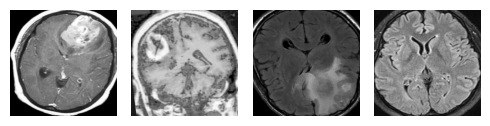

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5834 - loss: 0.9987 - val_accuracy: 0.5581 - val_loss: 0.6754
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7882 - loss: 0.4532 - val_accuracy: 0.8065 - val_loss: 0.6406
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8215 - loss: 0.3881 - val_accuracy: 0.8258 - val_loss: 0.6042
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8474 - loss: 0.3467 - val_accuracy: 0.8000 - val_loss: 0.5690
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8463 - loss: 0.3477 - val_accuracy: 0.5871 - val_loss: 0.5843
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8108 - loss: 0.3999 - val_accuracy: 0.8032 - val_loss: 0.4906
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8573 - loss: 0.3163 - val_accuracy: 0.8452 - val_loss: 0.4561
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8879 - loss: 0.2592 - val_accuracy: 0.8613 - val_loss:

{'test_loss': 0.36048808693885803,
 'test_accuracy': 0.8580645322799683,
 'val_f1_score': 0.8689655172413793,
 'test_f1_score': 0.8698224852071006}

In [16]:
experiment_name = "grayscale"
model = build_model((IMG_WIDTH, IMG_HEIGHT, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X, y = load_data(
    [original_augmented_yes, original_augmented_no],
    (IMG_WIDTH, IMG_HEIGHT),
    grayscale=True,
    contrast_enhancement=False,
    anisotropic_diffusion=False,
    smoothing=False,
    bilateral_filtering=False
)

plot_example_images(X, experiment_name)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

# Static file path to ensure only the best model is saved
filepath = os.path.join(model_dir, f"{experiment_name}.keras")

# Save only the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

start_time = time.time()

# Train the model without checkpointing
model.fit(x=X_train, y=y_train, batch_size=32, epochs=EPOCHS, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint], verbose=1)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"{experiment_name} - Elapsed time: {hms_string(execution_time)}")

evaluate(model, X_test, y_test, X_val, y_val)

# Contrast Enhancement


Running experiment: contrast_enhancement_clip2.0_grid4
Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


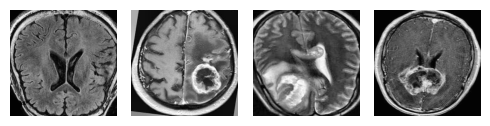

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.4846 - loss: 1.6154 - val_accuracy: 0.5839 - val_loss: 0.6740
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6522 - loss: 0.6346 - val_accuracy: 0.7258 - val_loss: 0.5830
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7681 - loss: 0.4783 - val_accuracy: 0.7774 - val_loss: 0.5308
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8274 - loss: 0.3999 - val_accuracy: 0.8129 - val_loss: 0.4849
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8577 - loss: 0.3460 - val_accuracy: 0.8065 - val_loss: 0.4580
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8698 - loss: 0.3144 - val_accuracy: 0.7516 - val_loss: 0.4820
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8923 - loss: 0.2882 - val_accuracy: 0.8419 - val_loss: 0.3730
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8913 - loss: 0.2744 - val_accuracy: 0.8032 - val_loss:

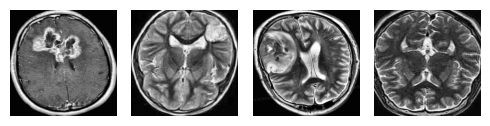

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5373 - loss: 1.3964 - val_accuracy: 0.6548 - val_loss: 0.6597
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7600 - loss: 0.4894 - val_accuracy: 0.8065 - val_loss: 0.5898
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8521 - loss: 0.3642 - val_accuracy: 0.8000 - val_loss: 0.5342
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8735 - loss: 0.3181 - val_accuracy: 0.8806 - val_loss: 0.4482
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8877 - loss: 0.2793 - val_accuracy: 0.8548 - val_loss: 0.4088
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9062 - loss: 0.2492 - val_accuracy: 0.8452 - val_loss: 0.3728
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9221 - loss: 0.2221 - val_accuracy: 0.8065 - val_loss: 0.3866
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9272 - loss: 0.2009 - val_accuracy: 0.8065 - val_loss:

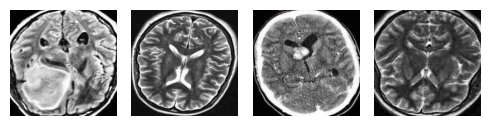

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5520 - loss: 1.1684 - val_accuracy: 0.5581 - val_loss: 0.6669
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7753 - loss: 0.4900 - val_accuracy: 0.7161 - val_loss: 0.6041
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8411 - loss: 0.3687 - val_accuracy: 0.7710 - val_loss: 0.5425
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8871 - loss: 0.3019 - val_accuracy: 0.7323 - val_loss: 0.5308
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9069 - loss: 0.2557 - val_accuracy: 0.6452 - val_loss: 0.6132
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9097 - loss: 0.2386 - val_accuracy: 0.5613 - val_loss: 0.8353
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8995 - loss: 0.2505 - val_accuracy: 0.6161 - val_loss: 0.7857
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8843 - loss: 0.2550 - val_accuracy: 0.5452 - val_loss:

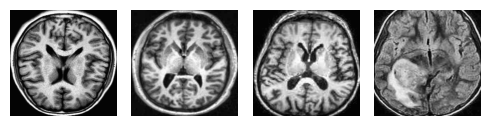

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5497 - loss: 1.3282 - val_accuracy: 0.5452 - val_loss: 0.7010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7423 - loss: 0.5438 - val_accuracy: 0.6419 - val_loss: 0.6147
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7930 - loss: 0.4691 - val_accuracy: 0.7581 - val_loss: 0.5431
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7940 - loss: 0.4386 - val_accuracy: 0.8000 - val_loss: 0.4928
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8236 - loss: 0.4015 - val_accuracy: 0.7903 - val_loss: 0.4643
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8659 - loss: 0.3415 - val_accuracy: 0.8161 - val_loss: 0.4297
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8773 - loss: 0.3067 - val_accuracy: 0.7323 - val_loss: 0.4784
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8746 - loss: 0.3027 - val_accuracy: 0.7419 - val_loss:

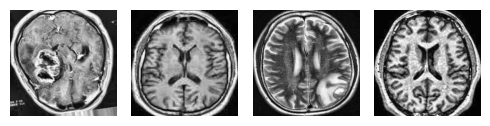

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5358 - loss: 1.5014 - val_accuracy: 0.6000 - val_loss: 0.6625
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7429 - loss: 0.5309 - val_accuracy: 0.6000 - val_loss: 0.6273
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8283 - loss: 0.4145 - val_accuracy: 0.7903 - val_loss: 0.5301
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8645 - loss: 0.3555 - val_accuracy: 0.8258 - val_loss: 0.4830
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8832 - loss: 0.3093 - val_accuracy: 0.8194 - val_loss: 0.4418
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8728 - loss: 0.2995 - val_accuracy: 0.8516 - val_loss: 0.3984
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8656 - loss: 0.3044 - val_accuracy: 0.8677 - val_loss: 0.3535
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9011 - loss: 0.2587 - val_accuracy: 0.7645 - val_loss:

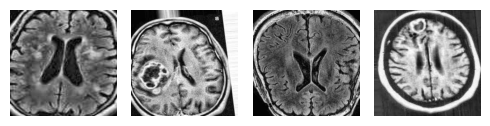

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5092 - loss: 1.8538 - val_accuracy: 0.5419 - val_loss: 0.7164
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6832 - loss: 0.6306 - val_accuracy: 0.5742 - val_loss: 0.6467
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7584 - loss: 0.5095 - val_accuracy: 0.7839 - val_loss: 0.5352
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8152 - loss: 0.4298 - val_accuracy: 0.8613 - val_loss: 0.4797
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8544 - loss: 0.3622 - val_accuracy: 0.8258 - val_loss: 0.4516
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8861 - loss: 0.3128 - val_accuracy: 0.8258 - val_loss: 0.4207
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8856 - loss: 0.3082 - val_accuracy: 0.7677 - val_loss: 0.4422
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8936 - loss: 0.2831 - val_accuracy: 0.8645 - val_loss:

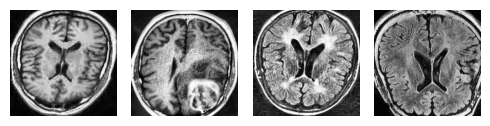

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.4913 - loss: 1.6965 - val_accuracy: 0.4903 - val_loss: 0.6883
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7077 - loss: 0.5725 - val_accuracy: 0.7000 - val_loss: 0.6073
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7464 - loss: 0.5252 - val_accuracy: 0.7097 - val_loss: 0.5631
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7789 - loss: 0.4710 - val_accuracy: 0.6871 - val_loss: 0.5526
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7946 - loss: 0.4341 - val_accuracy: 0.7161 - val_loss: 0.5181
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8273 - loss: 0.3944 - val_accuracy: 0.7097 - val_loss: 0.5064
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8259 - loss: 0.3756 - val_accuracy: 0.7516 - val_loss: 0.4617
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8529 - loss: 0.3370 - val_accuracy: 0.7613 - val_loss:

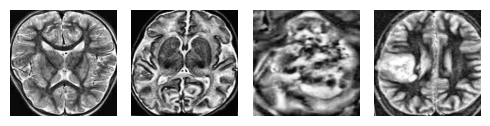

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5255 - loss: 1.6075 - val_accuracy: 0.5161 - val_loss: 0.7242
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6542 - loss: 0.6078 - val_accuracy: 0.6903 - val_loss: 0.5979
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8050 - loss: 0.4649 - val_accuracy: 0.6935 - val_loss: 0.5704
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8298 - loss: 0.3976 - val_accuracy: 0.7903 - val_loss: 0.5050
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8583 - loss: 0.3474 - val_accuracy: 0.8419 - val_loss: 0.4448
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8581 - loss: 0.3300 - val_accuracy: 0.6935 - val_loss: 0.5259
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8850 - loss: 0.2933 - val_accuracy: 0.7613 - val_loss: 0.4556
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8923 - loss: 0.2736 - val_accuracy: 0.6774 - val_loss:

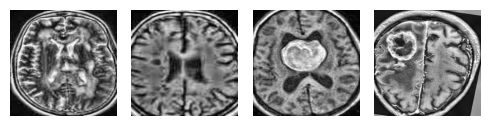

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5198 - loss: 1.4880 - val_accuracy: 0.6484 - val_loss: 0.6586
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7117 - loss: 0.5561 - val_accuracy: 0.6871 - val_loss: 0.6048
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7382 - loss: 0.5165 - val_accuracy: 0.7968 - val_loss: 0.5318
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7930 - loss: 0.4419 - val_accuracy: 0.8065 - val_loss: 0.4817
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8177 - loss: 0.3934 - val_accuracy: 0.8452 - val_loss: 0.4319
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8491 - loss: 0.3545 - val_accuracy: 0.8290 - val_loss: 0.4099
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8466 - loss: 0.3382 - val_accuracy: 0.7161 - val_loss: 0.5145
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8758 - loss: 0.3070 - val_accuracy: 0.7032 - val_loss:

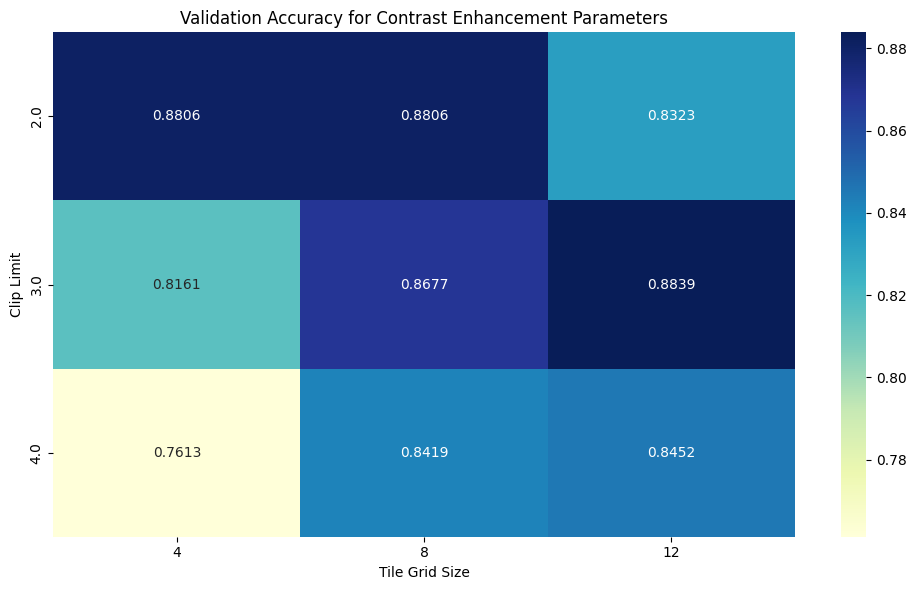


Grid Search Results:
Experiment: contrast_enhancement_clip2.0_grid4, Val Accuracy: 0.8806, Time: 0:8:35.8
Experiment: contrast_enhancement_clip2.0_grid8, Val Accuracy: 0.8806, Time: 0:8:45.7
Experiment: contrast_enhancement_clip2.0_grid12, Val Accuracy: 0.8323, Time: 0:8:44.3
Experiment: contrast_enhancement_clip3.0_grid4, Val Accuracy: 0.8161, Time: 0:8:45.5
Experiment: contrast_enhancement_clip3.0_grid8, Val Accuracy: 0.8677, Time: 0:8:47.5
Experiment: contrast_enhancement_clip3.0_grid12, Val Accuracy: 0.8839, Time: 0:8:49.2
Experiment: contrast_enhancement_clip4.0_grid4, Val Accuracy: 0.7613, Time: 0:8:47.8
Experiment: contrast_enhancement_clip4.0_grid8, Val Accuracy: 0.8419, Time: 0:8:53.7
Experiment: contrast_enhancement_clip4.0_grid12, Val Accuracy: 0.8452, Time: 0:8:53.7

Best Parameters: {'clip_limit': 3.0, 'tile_grid_size': 12}
Best Validation Accuracy: 0.8839

Test Metrics for Best Parameters (contrast_enhancement_clip3.0_grid12):
test_loss: 0.3645
test_accuracy: 0.8484
val_

<Figure size 640x480 with 0 Axes>

In [17]:
param_grid = {
    'clip_limit': [2.0, 3.0, 4.0],
    'tile_grid_size': [4, 8, 12]
}

best_val_accuracy = 0
best_params = None
results = []

for params in ParameterGrid(param_grid):
    clip_limit = params['clip_limit']
    tile_grid_size = params['tile_grid_size']

    experiment_name = f"contrast_enhancement_clip{clip_limit}_grid{tile_grid_size}"
    print(f"\nRunning experiment: {experiment_name}")

    model = build_model(IMG_SHAPE)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X, y = load_data(
        [original_augmented_yes, original_augmented_no],
        (IMG_WIDTH, IMG_HEIGHT),
        grayscale=False,
        contrast_enhancement=True,
        anisotropic_diffusion=False,
        smoothing=False,
        bilateral_filtering=False,
        clip_limit=clip_limit,
        tile_grid_size=tile_grid_size
    )

    plot_example_images(X, f"{experiment_name}_{clip_limit}_grid{tile_grid_size}")

    # Split the data
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

    # Define file path for saving the model
    filepath = os.path.join(model_dir, f"{experiment_name}.keras")
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    # Train the model
    start_time = time.time()
    history = model.fit(
        x=X_train, y=y_train,
        batch_size=32,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[checkpoint],
        verbose=1
    )
    end_time = time.time()
    execution_time = end_time - start_time

    # Get the best validation accuracy from this run
    val_accuracy = max(history.history['val_accuracy'])
    print(f"{experiment_name} - Elapsed time: {hms_string(execution_time)} - Val Accuracy: {val_accuracy:.4f}")

    # Evaluate on test set
    test_metrics = evaluate(model, X_test, y_test, X_val, y_val)

    # Store results
    results.append({
        'experiment_name': experiment_name,
        'clip_limit': clip_limit,
        'tile_grid_size': tile_grid_size,
        'val_accuracy': val_accuracy,
        'test_metrics': test_metrics,
        'execution_time': execution_time
    })

    # Update best parameters if this run is better
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params

# Prepare data for heatmap
clip_limits = param_grid['clip_limit']
tile_grid_sizes = param_grid['tile_grid_size']
val_accuracies = np.zeros((len(clip_limits), len(tile_grid_sizes)))

for result in results:
    i = clip_limits.index(result['clip_limit'])
    j = tile_grid_sizes.index(result['tile_grid_size'])
    val_accuracies[i, j] = result['val_accuracy']

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=tile_grid_sizes, yticklabels=clip_limits, cmap="YlGnBu")
plt.title("Validation Accuracy for Contrast Enhancement Parameters")
plt.xlabel("Tile Grid Size")
plt.ylabel("Clip Limit")
plt.tight_layout()
plt.show()
plt.savefig(f"images/{experiment_name}_grid-search.png", dpi=300)

# Print grid search results
print("\nGrid Search Results:")
for result in results:
    print(f"Experiment: {result['experiment_name']}, Val Accuracy: {result['val_accuracy']:.4f}, "
          f"Time: {hms_string(result['execution_time'])}")

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Print test metrics for the best parameters
best_result = next(r for r in results if r['clip_limit'] == best_params['clip_limit'] and r['tile_grid_size'] == best_params['tile_grid_size'])
print(f"\nTest Metrics for Best Parameters ({best_result['experiment_name']}):")
for metric_name, metric_value in best_result['test_metrics'].items():
    print(f"{metric_name}: {metric_value:.4f}")

# Average Smoothing Filtering


Running experiment: smoothing_kernel5
Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


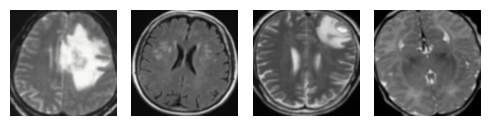

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5528 - loss: 1.0791 - val_accuracy: 0.6226 - val_loss: 0.6556
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7194 - loss: 0.5391 - val_accuracy: 0.7516 - val_loss: 0.6123
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7939 - loss: 0.4489 - val_accuracy: 0.7935 - val_loss: 0.5709
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8311 - loss: 0.4074 - val_accuracy: 0.7355 - val_loss: 0.5436
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8319 - loss: 0.3722 - val_accuracy: 0.8387 - val_loss: 0.4745
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8705 - loss: 0.3123 - val_accuracy: 0.8516 - val_loss: 0.4208
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8843 - loss: 0.2719 - val_accuracy: 0.8452 - val_loss: 0.3910
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9034 - loss: 0.2424 - val_accuracy: 0.8226 - val_loss:

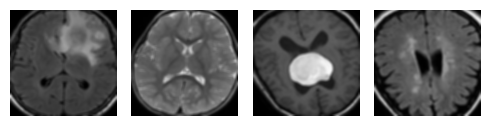

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5710 - loss: 0.8463 - val_accuracy: 0.5968 - val_loss: 0.6750
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7368 - loss: 0.5568 - val_accuracy: 0.5161 - val_loss: 0.6820
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7420 - loss: 0.5458 - val_accuracy: 0.6774 - val_loss: 0.6179
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7644 - loss: 0.5307 - val_accuracy: 0.5613 - val_loss: 0.6645
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7650 - loss: 0.5220 - val_accuracy: 0.6645 - val_loss: 0.5896
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8057 - loss: 0.4305 - val_accuracy: 0.7000 - val_loss: 0.5571
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8329 - loss: 0.3896 - val_accuracy: 0.7645 - val_loss: 0.4803
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8514 - loss: 0.3397 - val_accuracy: 0.7968 - val_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.984279490192421e-16..0.9257806895410313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.557953848736361e-16..0.7832001994930062].


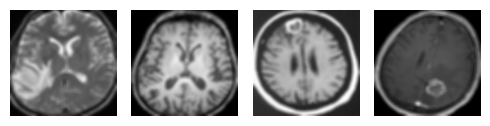

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5892 - loss: 0.8446 - val_accuracy: 0.5258 - val_loss: 0.6727
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7198 - loss: 0.5683 - val_accuracy: 0.6903 - val_loss: 0.6368
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7816 - loss: 0.4696 - val_accuracy: 0.7323 - val_loss: 0.6051
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8258 - loss: 0.4029 - val_accuracy: 0.8194 - val_loss: 0.5670
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8465 - loss: 0.3599 - val_accuracy: 0.8032 - val_loss: 0.5245
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8667 - loss: 0.3329 - val_accuracy: 0.8290 - val_loss: 0.4855
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8768 - loss: 0.3065 - val_accuracy: 0.8226 - val_loss: 0.4475
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8824 - loss: 0.2871 - val_accuracy: 0.7871 - val_loss:

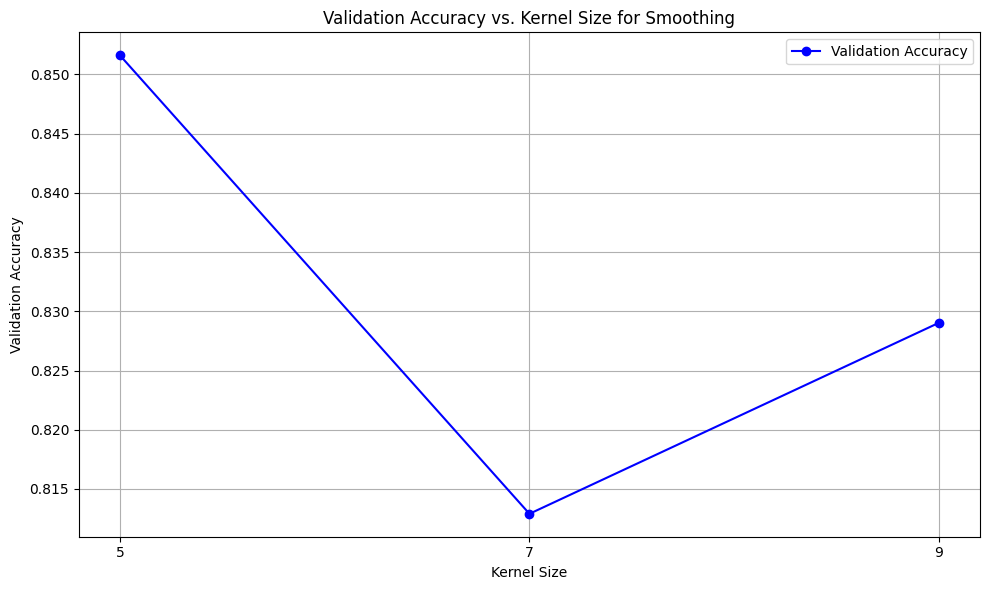


Grid Search Results:
Experiment: smoothing_kernel5, Val Accuracy: 0.8516, Time: 0:8:57.7
Experiment: smoothing_kernel7, Val Accuracy: 0.8129, Time: 0:8:56.3
Experiment: smoothing_kernel9, Val Accuracy: 0.8290, Time: 0:8:54.4

Best Parameters: {'kernel_size': 5}
Best Validation Accuracy: 0.8516

Test Metrics for Best Parameters (smoothing_kernel5):
test_loss: 0.5681
test_accuracy: 0.7613
val_f1_score: 0.6905
test_f1_score: 0.7109


<Figure size 640x480 with 0 Axes>

In [18]:
param_grid = {
    'kernel_size': [5, 7, 9]
}

best_val_accuracy = 0
best_params = None
results = []

for params in ParameterGrid(param_grid):
    kernel_size = params['kernel_size']

    experiment_name = f"smoothing_kernel{kernel_size}"
    print(f"\nRunning experiment: {experiment_name}")

    model = build_model(IMG_SHAPE)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X, y = load_data(
        [original_augmented_yes, original_augmented_no],
        (IMG_WIDTH, IMG_HEIGHT),
        grayscale=False,
        contrast_enhancement=False,
        anisotropic_diffusion=False,
        smoothing=True,
        bilateral_filtering=False,
        kernel_size=kernel_size
    )

    plot_example_images(X, f"{experiment_name}_{kernel_size}")

    # Split the data
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

    # Define file path for saving the model
    filepath = os.path.join(model_dir, f"{experiment_name}.keras")
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    # Train the model
    start_time = time.time()
    history = model.fit(
        x=X_train, y=y_train,
        batch_size=32,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[checkpoint],
        verbose=1
    )
    end_time = time.time()
    execution_time = end_time - start_time

    # Get the best validation accuracy from this run
    val_accuracy = max(history.history['val_accuracy'])
    print(f"{experiment_name} - Elapsed time: {hms_string(execution_time)} - Val Accuracy: {val_accuracy:.4f}")

    # Evaluate on test set
    test_metrics = evaluate(model, X_test, y_test, X_val, y_val)

    # Store results
    results.append({
        'experiment_name': experiment_name,
        'kernel_size': kernel_size,
        'val_accuracy': val_accuracy,
        'test_metrics': test_metrics,
        'execution_time': execution_time
    })

    # Update best parameters if this run is better
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params

# Prepare data for plotting
kernel_sizes = [result['kernel_size'] for result in results]
val_accuracies = [result['val_accuracy'] for result in results]

# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(kernel_sizes, val_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.title("Validation Accuracy vs. Kernel Size for Smoothing")
plt.xlabel("Kernel Size")
plt.ylabel("Validation Accuracy")
plt.xticks(kernel_sizes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(f"images/{experiment_name}_grid-search.png", dpi=300)

# Print grid search results
print("\nGrid Search Results:")
for result in results:
    print(f"Experiment: {result['experiment_name']}, Val Accuracy: {result['val_accuracy']:.4f}, "
          f"Time: {hms_string(result['execution_time'])}")

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Print test metrics for the best parameters
best_result = next(r for r in results if r['kernel_size'] == best_params['kernel_size'])
print(f"\nTest Metrics for Best Parameters ({best_result['experiment_name']}):")
for metric_name, metric_value in best_result['test_metrics'].items():
    print(f"{metric_name}: {metric_value:.4f}")

# Bilateral Filtering


Running experiment: bilateral_d5_sigmac10_sigmas10
Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


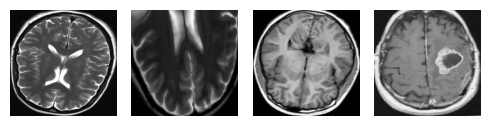

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5863 - loss: 1.0744 - val_accuracy: 0.6129 - val_loss: 0.6486
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7414 - loss: 0.5527 - val_accuracy: 0.7677 - val_loss: 0.5909
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7784 - loss: 0.4815 - val_accuracy: 0.7548 - val_loss: 0.5491
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7955 - loss: 0.4235 - val_accuracy: 0.6645 - val_loss: 0.5560
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8200 - loss: 0.3819 - val_accuracy: 0.6742 - val_loss: 0.5576
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8445 - loss: 0.3456 - val_accuracy: 0.6194 - val_loss: 0.6742
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8553 - loss: 0.3265 - val_accuracy: 0.6065 - val_loss: 0.7809
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8607 - loss: 0.2967 - val_accuracy: 0.6032 - val_loss:

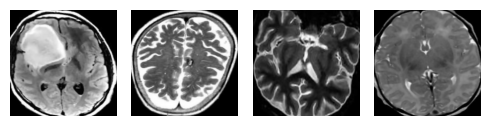

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5710 - loss: 1.0180 - val_accuracy: 0.5548 - val_loss: 0.6848
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7618 - loss: 0.5014 - val_accuracy: 0.6290 - val_loss: 0.6361
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7780 - loss: 0.4741 - val_accuracy: 0.7258 - val_loss: 0.5833
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7757 - loss: 0.4780 - val_accuracy: 0.7516 - val_loss: 0.5230
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8381 - loss: 0.3817 - val_accuracy: 0.7355 - val_loss: 0.5173
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8570 - loss: 0.3287 - val_accuracy: 0.7839 - val_loss: 0.4521
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8722 - loss: 0.2940 - val_accuracy: 0.7871 - val_loss: 0.4423
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8979 - loss: 0.2538 - val_accuracy: 0.7677 - val_loss:

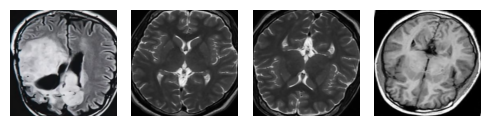

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5466 - loss: 1.1973 - val_accuracy: 0.5677 - val_loss: 0.6770
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7229 - loss: 0.5441 - val_accuracy: 0.5742 - val_loss: 0.6475
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7982 - loss: 0.4289 - val_accuracy: 0.7194 - val_loss: 0.5851
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8306 - loss: 0.3833 - val_accuracy: 0.6194 - val_loss: 0.6181
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8544 - loss: 0.3457 - val_accuracy: 0.5516 - val_loss: 0.7150
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8524 - loss: 0.3197 - val_accuracy: 0.7355 - val_loss: 0.5322
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8620 - loss: 0.2895 - val_accuracy: 0.6097 - val_loss: 0.6947
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8857 - loss: 0.2625 - val_accuracy: 0.5516 - val_loss:

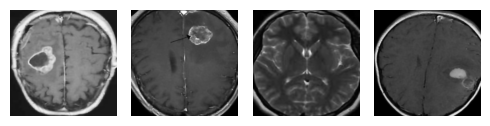

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5557 - loss: 1.2412 - val_accuracy: 0.5516 - val_loss: 0.6548
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7541 - loss: 0.4992 - val_accuracy: 0.7129 - val_loss: 0.6009
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7980 - loss: 0.4250 - val_accuracy: 0.7452 - val_loss: 0.5648
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8129 - loss: 0.3891 - val_accuracy: 0.8226 - val_loss: 0.5037
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8547 - loss: 0.3343 - val_accuracy: 0.8387 - val_loss: 0.4576
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8702 - loss: 0.2968 - val_accuracy: 0.8258 - val_loss: 0.4269
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8947 - loss: 0.2701 - val_accuracy: 0.7484 - val_loss: 0.4638
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9152 - loss: 0.2446 - val_accuracy: 0.8226 - val_loss:

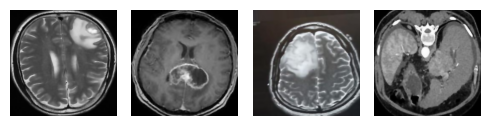

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5833 - loss: 0.9863 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7659 - loss: 0.4777 - val_accuracy: 0.6452 - val_loss: 0.6336
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8192 - loss: 0.4117 - val_accuracy: 0.7226 - val_loss: 0.5791
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8469 - loss: 0.3528 - val_accuracy: 0.7871 - val_loss: 0.5137
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8730 - loss: 0.3095 - val_accuracy: 0.8032 - val_loss: 0.4732
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8962 - loss: 0.2768 - val_accuracy: 0.8290 - val_loss: 0.4331
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9090 - loss: 0.2522 - val_accuracy: 0.8516 - val_loss: 0.4004
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9232 - loss: 0.2364 - val_accuracy: 0.8032 - val_loss:

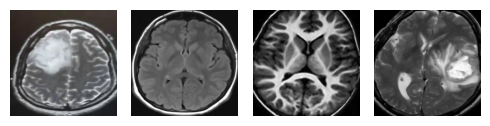

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5499 - loss: 1.1980 - val_accuracy: 0.4935 - val_loss: 0.6795
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7272 - loss: 0.5478 - val_accuracy: 0.7419 - val_loss: 0.6101
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8020 - loss: 0.4195 - val_accuracy: 0.6839 - val_loss: 0.5900
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8383 - loss: 0.3639 - val_accuracy: 0.8323 - val_loss: 0.5116
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8694 - loss: 0.3146 - val_accuracy: 0.8226 - val_loss: 0.4824
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8798 - loss: 0.2865 - val_accuracy: 0.8129 - val_loss: 0.4604
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9037 - loss: 0.2597 - val_accuracy: 0.8032 - val_loss: 0.4524
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9081 - loss: 0.2440 - val_accuracy: 0.8613 - val_loss:

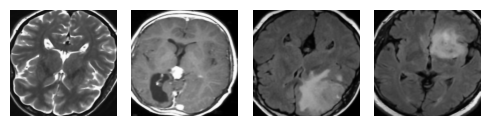

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5960 - loss: 0.9947 - val_accuracy: 0.5677 - val_loss: 0.6463
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7801 - loss: 0.4950 - val_accuracy: 0.6581 - val_loss: 0.6137
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8186 - loss: 0.4262 - val_accuracy: 0.7000 - val_loss: 0.5844
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8362 - loss: 0.3773 - val_accuracy: 0.7613 - val_loss: 0.5361
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8737 - loss: 0.3190 - val_accuracy: 0.6903 - val_loss: 0.5304
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8836 - loss: 0.3027 - val_accuracy: 0.7065 - val_loss: 0.5210
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8821 - loss: 0.2812 - val_accuracy: 0.6871 - val_loss: 0.5931
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8715 - loss: 0.2905 - val_accuracy: 0.7839 - val_loss:

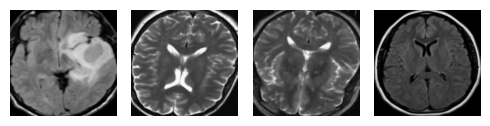

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5813 - loss: 1.1235 - val_accuracy: 0.6452 - val_loss: 0.6481
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7261 - loss: 0.5488 - val_accuracy: 0.7323 - val_loss: 0.6133
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7915 - loss: 0.4525 - val_accuracy: 0.7419 - val_loss: 0.5671
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8235 - loss: 0.3741 - val_accuracy: 0.7839 - val_loss: 0.5209
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8575 - loss: 0.3266 - val_accuracy: 0.8226 - val_loss: 0.4783
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8987 - loss: 0.2775 - val_accuracy: 0.8065 - val_loss: 0.4525
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9070 - loss: 0.2538 - val_accuracy: 0.8290 - val_loss: 0.4148
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9146 - loss: 0.2317 - val_accuracy: 0.8355 - val_loss:

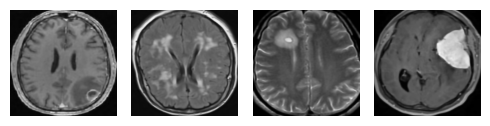

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5640 - loss: 1.0032 - val_accuracy: 0.5452 - val_loss: 0.6693
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7772 - loss: 0.4887 - val_accuracy: 0.6839 - val_loss: 0.6168
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7996 - loss: 0.4475 - val_accuracy: 0.7903 - val_loss: 0.5673
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8287 - loss: 0.3848 - val_accuracy: 0.7452 - val_loss: 0.5392
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8634 - loss: 0.3368 - val_accuracy: 0.7871 - val_loss: 0.5008
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8840 - loss: 0.2932 - val_accuracy: 0.8000 - val_loss: 0.4650
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9087 - loss: 0.2519 - val_accuracy: 0.8194 - val_loss: 0.4320
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9197 - loss: 0.2224 - val_accuracy: 0.8258 - val_loss:

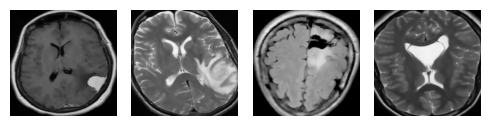

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5929 - loss: 1.0672 - val_accuracy: 0.7129 - val_loss: 0.6314
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7746 - loss: 0.4824 - val_accuracy: 0.7258 - val_loss: 0.5960
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8205 - loss: 0.4106 - val_accuracy: 0.7097 - val_loss: 0.5463
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8483 - loss: 0.3543 - val_accuracy: 0.7806 - val_loss: 0.4895
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8645 - loss: 0.3181 - val_accuracy: 0.8194 - val_loss: 0.4584
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8878 - loss: 0.2849 - val_accuracy: 0.8161 - val_loss: 0.4370
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8943 - loss: 0.2500 - val_accuracy: 0.8516 - val_loss: 0.3866
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9122 - loss: 0.2274 - val_accuracy: 0.8548 - val_loss:

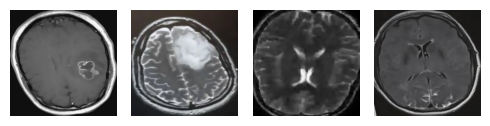

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5668 - loss: 1.2278 - val_accuracy: 0.5161 - val_loss: 0.6816
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7615 - loss: 0.4837 - val_accuracy: 0.7452 - val_loss: 0.5977
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7934 - loss: 0.4482 - val_accuracy: 0.6968 - val_loss: 0.5718
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8346 - loss: 0.3775 - val_accuracy: 0.7323 - val_loss: 0.5371
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8787 - loss: 0.3112 - val_accuracy: 0.7968 - val_loss: 0.4753
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9028 - loss: 0.2754 - val_accuracy: 0.8065 - val_loss: 0.4357
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9056 - loss: 0.2502 - val_accuracy: 0.7935 - val_loss: 0.4538
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9215 - loss: 0.2336 - val_accuracy: 0.8226 - val_loss:

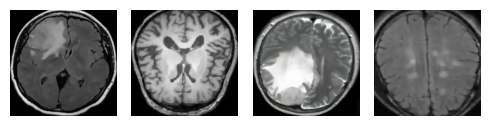

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5688 - loss: 1.0609 - val_accuracy: 0.6097 - val_loss: 0.6694
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7531 - loss: 0.5176 - val_accuracy: 0.7161 - val_loss: 0.6226
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8202 - loss: 0.4323 - val_accuracy: 0.7516 - val_loss: 0.5769
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8626 - loss: 0.3401 - val_accuracy: 0.7774 - val_loss: 0.5358
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8771 - loss: 0.3110 - val_accuracy: 0.8032 - val_loss: 0.4943
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8889 - loss: 0.2721 - val_accuracy: 0.8032 - val_loss: 0.4592
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8977 - loss: 0.2483 - val_accuracy: 0.8323 - val_loss: 0.4190
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9219 - loss: 0.2204 - val_accuracy: 0.8161 - val_loss:

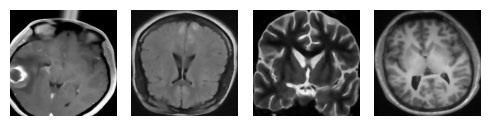

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5872 - loss: 0.9253 - val_accuracy: 0.5129 - val_loss: 0.7347
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7724 - loss: 0.4730 - val_accuracy: 0.5710 - val_loss: 0.6501
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8410 - loss: 0.3864 - val_accuracy: 0.5677 - val_loss: 0.6530
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8545 - loss: 0.3349 - val_accuracy: 0.7161 - val_loss: 0.5724
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8819 - loss: 0.3020 - val_accuracy: 0.6742 - val_loss: 0.6023
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8881 - loss: 0.2876 - val_accuracy: 0.7581 - val_loss: 0.5199
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8910 - loss: 0.2733 - val_accuracy: 0.8000 - val_loss: 0.4628
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8927 - loss: 0.2526 - val_accuracy: 0.8194 - val_loss:

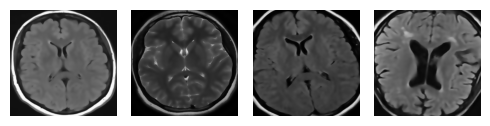

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5548 - loss: 1.1631 - val_accuracy: 0.5968 - val_loss: 0.6426
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7431 - loss: 0.5388 - val_accuracy: 0.7677 - val_loss: 0.6035
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7911 - loss: 0.4475 - val_accuracy: 0.7581 - val_loss: 0.5715
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8355 - loss: 0.3857 - val_accuracy: 0.7355 - val_loss: 0.5459
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8612 - loss: 0.3436 - val_accuracy: 0.7645 - val_loss: 0.4970
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8714 - loss: 0.3119 - val_accuracy: 0.8613 - val_loss: 0.4035
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8924 - loss: 0.2737 - val_accuracy: 0.7677 - val_loss: 0.4727
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9046 - loss: 0.2495 - val_accuracy: 0.6710 - val_loss:

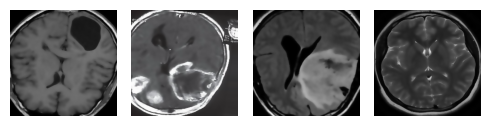

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5653 - loss: 1.1538 - val_accuracy: 0.6677 - val_loss: 0.6567
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7742 - loss: 0.4744 - val_accuracy: 0.7226 - val_loss: 0.6107
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7978 - loss: 0.4261 - val_accuracy: 0.7452 - val_loss: 0.5773
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8287 - loss: 0.3793 - val_accuracy: 0.5677 - val_loss: 0.6616
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8442 - loss: 0.3484 - val_accuracy: 0.6258 - val_loss: 0.6042
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8697 - loss: 0.3021 - val_accuracy: 0.6903 - val_loss: 0.5369
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8923 - loss: 0.2735 - val_accuracy: 0.7419 - val_loss: 0.4895
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9038 - loss: 0.2490 - val_accuracy: 0.8065 - val_loss:

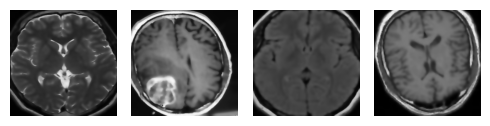

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5911 - loss: 0.9863 - val_accuracy: 0.5452 - val_loss: 0.6660
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7448 - loss: 0.5265 - val_accuracy: 0.7097 - val_loss: 0.6247
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7871 - loss: 0.4523 - val_accuracy: 0.7258 - val_loss: 0.5942
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8129 - loss: 0.3872 - val_accuracy: 0.7677 - val_loss: 0.5597
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8339 - loss: 0.3380 - val_accuracy: 0.7839 - val_loss: 0.5252
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8600 - loss: 0.3085 - val_accuracy: 0.8000 - val_loss: 0.4918
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8855 - loss: 0.2761 - val_accuracy: 0.7935 - val_loss: 0.4925
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9001 - loss: 0.2538 - val_accuracy: 0.7968 - val_loss:

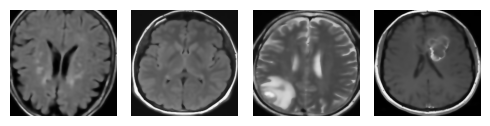

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5686 - loss: 0.8659 - val_accuracy: 0.5258 - val_loss: 0.6821
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7493 - loss: 0.5406 - val_accuracy: 0.6129 - val_loss: 0.6344
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7831 - loss: 0.4661 - val_accuracy: 0.6774 - val_loss: 0.5983
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8224 - loss: 0.3991 - val_accuracy: 0.7645 - val_loss: 0.5540
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8493 - loss: 0.3375 - val_accuracy: 0.7806 - val_loss: 0.5108
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8837 - loss: 0.2888 - val_accuracy: 0.7806 - val_loss: 0.4801
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9100 - loss: 0.2527 - val_accuracy: 0.8129 - val_loss: 0.4525
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9059 - loss: 0.2416 - val_accuracy: 0.8194 - val_loss:

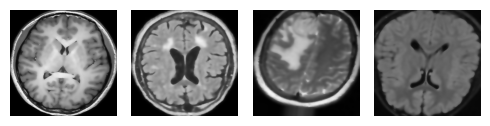

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5911 - loss: 1.0098 - val_accuracy: 0.5419 - val_loss: 0.7241
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7110 - loss: 0.5998 - val_accuracy: 0.5613 - val_loss: 0.6803
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7405 - loss: 0.5498 - val_accuracy: 0.5806 - val_loss: 0.6483
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7564 - loss: 0.5218 - val_accuracy: 0.6065 - val_loss: 0.6251
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7800 - loss: 0.4693 - val_accuracy: 0.7065 - val_loss: 0.5510
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8400 - loss: 0.3840 - val_accuracy: 0.7258 - val_loss: 0.5453
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8664 - loss: 0.3423 - val_accuracy: 0.7806 - val_loss: 0.4565
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8919 - loss: 0.2967 - val_accuracy: 0.7935 - val_loss:

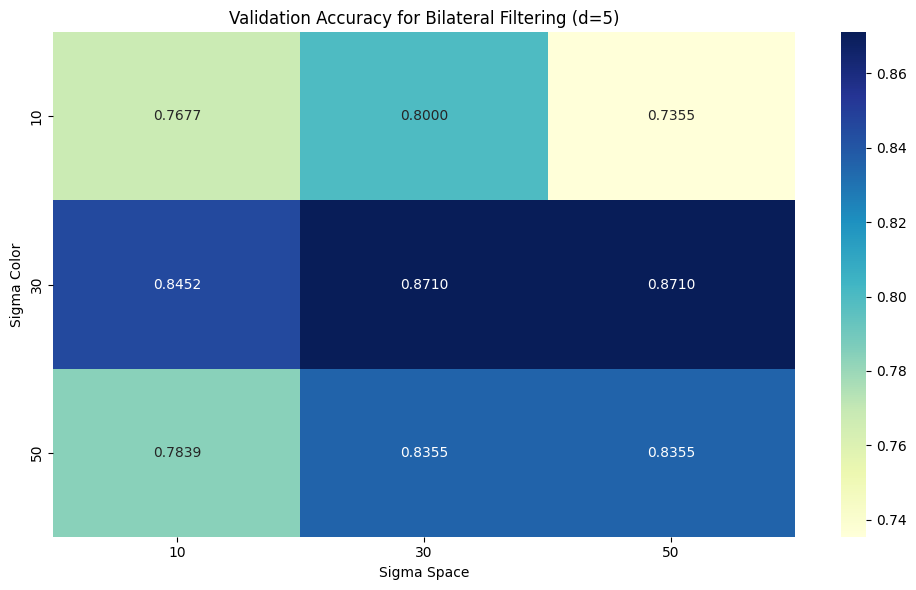


Grid Search Results:
Experiment: bilateral_d5_sigmac10_sigmas10, Val Accuracy: 0.7677, Time: 0:8:55.9
Experiment: bilateral_d5_sigmac10_sigmas30, Val Accuracy: 0.8000, Time: 0:9:25.6
Experiment: bilateral_d5_sigmac10_sigmas50, Val Accuracy: 0.7355, Time: 0:9:4.2
Experiment: bilateral_d5_sigmac30_sigmas10, Val Accuracy: 0.8452, Time: 0:9:58.0
Experiment: bilateral_d5_sigmac30_sigmas30, Val Accuracy: 0.8710, Time: 0:8:56.2
Experiment: bilateral_d5_sigmac30_sigmas50, Val Accuracy: 0.8710, Time: 0:9:1.3
Experiment: bilateral_d5_sigmac50_sigmas10, Val Accuracy: 0.7839, Time: 0:8:54.8
Experiment: bilateral_d5_sigmac50_sigmas30, Val Accuracy: 0.8355, Time: 0:8:59.3
Experiment: bilateral_d5_sigmac50_sigmas50, Val Accuracy: 0.8355, Time: 0:9:3.0
Experiment: bilateral_d9_sigmac10_sigmas10, Val Accuracy: 0.8613, Time: 0:9:27.6
Experiment: bilateral_d9_sigmac10_sigmas30, Val Accuracy: 0.8452, Time: 0:10:6.8
Experiment: bilateral_d9_sigmac10_sigmas50, Val Accuracy: 0.8516, Time: 0:8:56.7
Experimen

<Figure size 640x480 with 0 Axes>

In [19]:
param_grid = {
    'd': [5, 9],
    'sigma_color': [10, 30, 50],
    'sigma_space': [10, 30, 50]
}

best_val_accuracy = 0
best_params = None
results = []

for params in ParameterGrid(param_grid):
    d = params['d']
    sigma_color = params['sigma_color']
    sigma_space = params['sigma_space']

    experiment_name = f"bilateral_d{d}_sigmac{sigma_color}_sigmas{sigma_space}"
    print(f"\nRunning experiment: {experiment_name}")

    model = build_model(IMG_SHAPE)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X, y = load_data(
        [original_augmented_yes, original_augmented_no],
        (IMG_WIDTH, IMG_HEIGHT),
        grayscale=False,
        contrast_enhancement=False,
        anisotropic_diffusion=False,
        smoothing=False,
        bilateral_filtering=True,
        d=d,
        sigma_color=sigma_color,
        sigma_space=sigma_space
    )

    plot_example_images(X, f"{experiment_name}_d{d}_sigmac{sigma_color}_sigmas{sigma_space}")

    # Split the data
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

    # Define file path for saving the model
    filepath = os.path.join(model_dir, f"{experiment_name}.keras")
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    # Train the model
    start_time = time.time()
    history = model.fit(
        x=X_train, y=y_train,
        batch_size=32,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[checkpoint],
        verbose=1
    )
    end_time = time.time()
    execution_time = end_time - start_time

    # Get the best validation accuracy from this run
    val_accuracy = max(history.history['val_accuracy'])
    print(f"{experiment_name} - Elapsed time: {hms_string(execution_time)} - Val Accuracy: {val_accuracy:.4f}")

    # Evaluate on test set
    test_metrics = evaluate(model, X_test, y_test, X_val, y_val)

    # Store results
    results.append({
        'experiment_name': experiment_name,
        'd': d,
        'sigma_color': sigma_color,
        'sigma_space': sigma_space,
        'val_accuracy': val_accuracy,
        'test_metrics': test_metrics,
        'execution_time': execution_time
    })

    # Update best parameters if this run is better
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params

# Find the best 'd' value and create a heatmap for sigma_color vs. sigma_space
best_d = best_params['d']
sigma_colors = param_grid['sigma_color']
sigma_spaces = param_grid['sigma_space']
val_accuracies = np.zeros((len(sigma_colors), len(sigma_spaces)))

for result in results:
    if result['d'] == best_d:
        i = sigma_colors.index(result['sigma_color'])
        j = sigma_spaces.index(result['sigma_space'])
        val_accuracies[i, j] = result['val_accuracy']

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=sigma_spaces, yticklabels=sigma_colors, cmap="YlGnBu")
plt.title(f"Validation Accuracy for Bilateral Filtering (d={best_d})")
plt.xlabel("Sigma Space")
plt.ylabel("Sigma Color")
plt.tight_layout()
plt.show()
plt.savefig(f"images/{experiment_name}_grid-search.png", dpi=300)

# Print grid search results
print("\nGrid Search Results:")
for result in results:
    print(f"Experiment: {result['experiment_name']}, Val Accuracy: {result['val_accuracy']:.4f}, "
          f"Time: {hms_string(result['execution_time'])}")

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Print test metrics for the best parameters
best_result = next(r for r in results if r['d'] == best_params['d'] and
                   r['sigma_color'] == best_params['sigma_color'] and
                   r['sigma_space'] == best_params['sigma_space'])
print(f"\nTest Metrics for Best Parameters ({best_result['experiment_name']}):")
for metric_name, metric_value in best_result['test_metrics'].items():
    print(f"{metric_name}: {metric_value:.4f}")

# Anisotropic Diffusion Filtering


Running experiment: anisotropic_niter5_kappa20_gamma0.05
Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


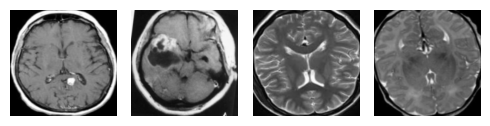

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5501 - loss: 1.0636 - val_accuracy: 0.6097 - val_loss: 0.6547
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7516 - loss: 0.4900 - val_accuracy: 0.7806 - val_loss: 0.6142
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8077 - loss: 0.4201 - val_accuracy: 0.8065 - val_loss: 0.5571
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8390 - loss: 0.3763 - val_accuracy: 0.8355 - val_loss: 0.5104
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8552 - loss: 0.3391 - val_accuracy: 0.8419 - val_loss: 0.4709
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8789 - loss: 0.3003 - val_accuracy: 0.8097 - val_loss: 0.4441
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8869 - loss: 0.2694 - val_accuracy: 0.8000 - val_loss: 0.4401
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8934 - loss: 0.2507 - val_accuracy: 0.7903 - val_loss:

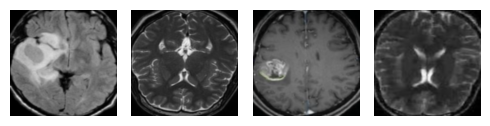

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5734 - loss: 1.0604 - val_accuracy: 0.6032 - val_loss: 0.6515
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7266 - loss: 0.5175 - val_accuracy: 0.7484 - val_loss: 0.6056
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7945 - loss: 0.4377 - val_accuracy: 0.7452 - val_loss: 0.5634
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8275 - loss: 0.3887 - val_accuracy: 0.7903 - val_loss: 0.5137
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8341 - loss: 0.3511 - val_accuracy: 0.7839 - val_loss: 0.4809
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8225 - loss: 0.3835 - val_accuracy: 0.7129 - val_loss: 0.5569
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7729 - loss: 0.5001 - val_accuracy: 0.7903 - val_loss: 0.4298
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7911 - loss: 0.4866 - val_accuracy: 0.7742 - val_loss:

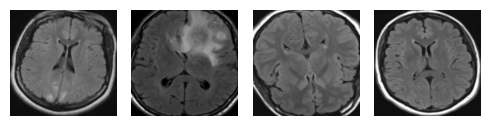

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5594 - loss: 1.0254 - val_accuracy: 0.6839 - val_loss: 0.6605
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7418 - loss: 0.5245 - val_accuracy: 0.7452 - val_loss: 0.6194
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7760 - loss: 0.4606 - val_accuracy: 0.7613 - val_loss: 0.5730
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8189 - loss: 0.3938 - val_accuracy: 0.8194 - val_loss: 0.5306
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8469 - loss: 0.3470 - val_accuracy: 0.8161 - val_loss: 0.4908
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8669 - loss: 0.3176 - val_accuracy: 0.8258 - val_loss: 0.4547
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8751 - loss: 0.3025 - val_accuracy: 0.8323 - val_loss: 0.4263
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8967 - loss: 0.2605 - val_accuracy: 0.8516 - val_loss:

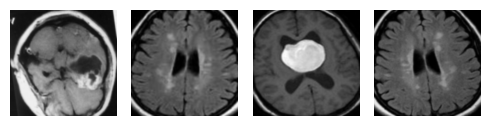

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5890 - loss: 0.9279 - val_accuracy: 0.6645 - val_loss: 0.6517
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7599 - loss: 0.4851 - val_accuracy: 0.6935 - val_loss: 0.6116
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8162 - loss: 0.4288 - val_accuracy: 0.7581 - val_loss: 0.5629
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8251 - loss: 0.4015 - val_accuracy: 0.8032 - val_loss: 0.5153
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8249 - loss: 0.3906 - val_accuracy: 0.7097 - val_loss: 0.5370
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7751 - loss: 0.4737 - val_accuracy: 0.7968 - val_loss: 0.4353
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8597 - loss: 0.3454 - val_accuracy: 0.7677 - val_loss: 0.4760
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8775 - loss: 0.2915 - val_accuracy: 0.8097 - val_loss:

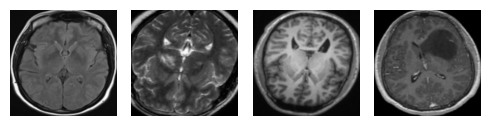

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5556 - loss: 1.1573 - val_accuracy: 0.5161 - val_loss: 0.6686
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7605 - loss: 0.5041 - val_accuracy: 0.5613 - val_loss: 0.6380
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7905 - loss: 0.4628 - val_accuracy: 0.6419 - val_loss: 0.6035
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8048 - loss: 0.4194 - val_accuracy: 0.6613 - val_loss: 0.5782
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8213 - loss: 0.3836 - val_accuracy: 0.6968 - val_loss: 0.5582
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8473 - loss: 0.3548 - val_accuracy: 0.7839 - val_loss: 0.4586
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8584 - loss: 0.3197 - val_accuracy: 0.8387 - val_loss: 0.3933
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8697 - loss: 0.2948 - val_accuracy: 0.8387 - val_loss:

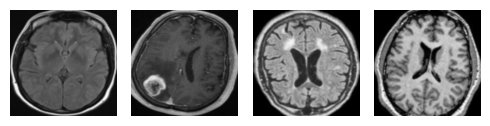

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5626 - loss: 1.0865 - val_accuracy: 0.6065 - val_loss: 0.6465
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7559 - loss: 0.5041 - val_accuracy: 0.7194 - val_loss: 0.6000
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7943 - loss: 0.4136 - val_accuracy: 0.7258 - val_loss: 0.5695
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8429 - loss: 0.3621 - val_accuracy: 0.7935 - val_loss: 0.5208
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8481 - loss: 0.3258 - val_accuracy: 0.7806 - val_loss: 0.4950
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8489 - loss: 0.3071 - val_accuracy: 0.7806 - val_loss: 0.4834
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8719 - loss: 0.2785 - val_accuracy: 0.7452 - val_loss: 0.5142
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8886 - loss: 0.2539 - val_accuracy: 0.7903 - val_loss:

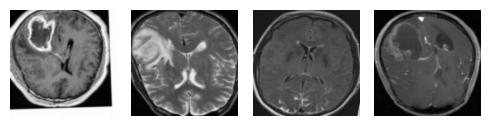

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5620 - loss: 0.8437 - val_accuracy: 0.5806 - val_loss: 0.6499
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7325 - loss: 0.5395 - val_accuracy: 0.7161 - val_loss: 0.6062
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8041 - loss: 0.4377 - val_accuracy: 0.5903 - val_loss: 0.5942
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8098 - loss: 0.4381 - val_accuracy: 0.6097 - val_loss: 0.5686
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8104 - loss: 0.4573 - val_accuracy: 0.6419 - val_loss: 0.5497
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7996 - loss: 0.5006 - val_accuracy: 0.6903 - val_loss: 0.5083
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8302 - loss: 0.4163 - val_accuracy: 0.7129 - val_loss: 0.5157
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8507 - loss: 0.3560 - val_accuracy: 0.7871 - val_loss:

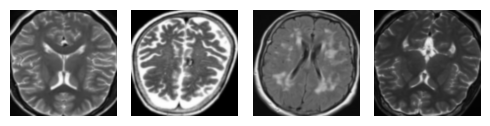

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5575 - loss: 1.0507 - val_accuracy: 0.6129 - val_loss: 0.6606
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7052 - loss: 0.5534 - val_accuracy: 0.7032 - val_loss: 0.6206
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7598 - loss: 0.4806 - val_accuracy: 0.7355 - val_loss: 0.5828
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8034 - loss: 0.4313 - val_accuracy: 0.7613 - val_loss: 0.5341
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8381 - loss: 0.3734 - val_accuracy: 0.7839 - val_loss: 0.4844
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8567 - loss: 0.3377 - val_accuracy: 0.7968 - val_loss: 0.4535
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8849 - loss: 0.3103 - val_accuracy: 0.7774 - val_loss: 0.4714
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8809 - loss: 0.3005 - val_accuracy: 0.7548 - val_loss:

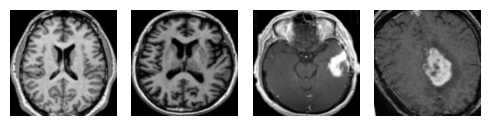

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5505 - loss: 1.1527 - val_accuracy: 0.5419 - val_loss: 0.6585
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6641 - loss: 0.6169 - val_accuracy: 0.7710 - val_loss: 0.6010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7749 - loss: 0.4877 - val_accuracy: 0.8097 - val_loss: 0.5536
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8062 - loss: 0.4222 - val_accuracy: 0.8129 - val_loss: 0.5060
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8270 - loss: 0.3829 - val_accuracy: 0.8355 - val_loss: 0.4612
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8583 - loss: 0.3389 - val_accuracy: 0.8516 - val_loss: 0.4091
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8680 - loss: 0.3085 - val_accuracy: 0.8452 - val_loss: 0.3841
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8831 - loss: 0.2911 - val_accuracy: 0.8258 - val_loss:

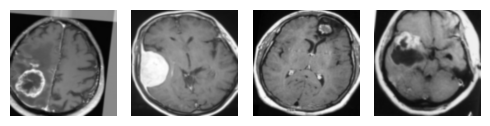

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5411 - loss: 1.1538 - val_accuracy: 0.5387 - val_loss: 0.6903
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7569 - loss: 0.5069 - val_accuracy: 0.5613 - val_loss: 0.6507
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8200 - loss: 0.4168 - val_accuracy: 0.6645 - val_loss: 0.5951
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8535 - loss: 0.3519 - val_accuracy: 0.7161 - val_loss: 0.5537
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8795 - loss: 0.3138 - val_accuracy: 0.7484 - val_loss: 0.5195
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8892 - loss: 0.2853 - val_accuracy: 0.7742 - val_loss: 0.4937
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8990 - loss: 0.2628 - val_accuracy: 0.8323 - val_loss: 0.4296
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9020 - loss: 0.2441 - val_accuracy: 0.8516 - val_loss:

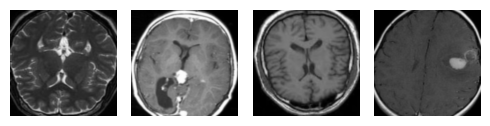

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6111 - loss: 0.7721 - val_accuracy: 0.5419 - val_loss: 0.6689
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7714 - loss: 0.4792 - val_accuracy: 0.5613 - val_loss: 0.6460
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8190 - loss: 0.4041 - val_accuracy: 0.5839 - val_loss: 0.6430
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8413 - loss: 0.3634 - val_accuracy: 0.5871 - val_loss: 0.6731
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8680 - loss: 0.3328 - val_accuracy: 0.6161 - val_loss: 0.6342
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8856 - loss: 0.2884 - val_accuracy: 0.6871 - val_loss: 0.5773
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9047 - loss: 0.2675 - val_accuracy: 0.7935 - val_loss: 0.4623
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9094 - loss: 0.2376 - val_accuracy: 0.7032 - val_loss:

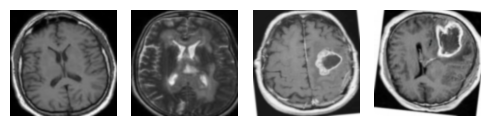

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6077 - loss: 0.7734 - val_accuracy: 0.5355 - val_loss: 0.6804
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7774 - loss: 0.4825 - val_accuracy: 0.5548 - val_loss: 0.6459
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7852 - loss: 0.4635 - val_accuracy: 0.5677 - val_loss: 0.6365
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7956 - loss: 0.4704 - val_accuracy: 0.6742 - val_loss: 0.5657
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7996 - loss: 0.4301 - val_accuracy: 0.7516 - val_loss: 0.4897
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8484 - loss: 0.3619 - val_accuracy: 0.7935 - val_loss: 0.4533
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8627 - loss: 0.3336 - val_accuracy: 0.8065 - val_loss: 0.4278
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8857 - loss: 0.3075 - val_accuracy: 0.7290 - val_loss:

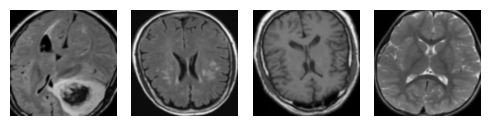

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5662 - loss: 1.0324 - val_accuracy: 0.6226 - val_loss: 0.6576
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6396 - loss: 0.7516 - val_accuracy: 0.7452 - val_loss: 0.6144
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6937 - loss: 0.6420 - val_accuracy: 0.6516 - val_loss: 0.5940
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7365 - loss: 0.6049 - val_accuracy: 0.6774 - val_loss: 0.5661
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7614 - loss: 0.5495 - val_accuracy: 0.6871 - val_loss: 0.5379
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7874 - loss: 0.4914 - val_accuracy: 0.6677 - val_loss: 0.5750
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8103 - loss: 0.4561 - val_accuracy: 0.7677 - val_loss: 0.4654
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8321 - loss: 0.4100 - val_accuracy: 0.7290 - val_loss:

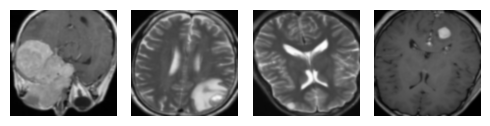

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6069 - loss: 0.8793 - val_accuracy: 0.6871 - val_loss: 0.6430
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7579 - loss: 0.5230 - val_accuracy: 0.7774 - val_loss: 0.6108
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7696 - loss: 0.5126 - val_accuracy: 0.7677 - val_loss: 0.5734
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7885 - loss: 0.4779 - val_accuracy: 0.7452 - val_loss: 0.5291
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7926 - loss: 0.4302 - val_accuracy: 0.7290 - val_loss: 0.5076
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8400 - loss: 0.3431 - val_accuracy: 0.7935 - val_loss: 0.4673
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8693 - loss: 0.3126 - val_accuracy: 0.7935 - val_loss: 0.4403
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8940 - loss: 0.2772 - val_accuracy: 0.8323 - val_loss:

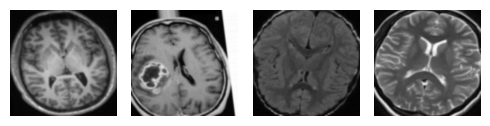

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5835 - loss: 0.9981 - val_accuracy: 0.6290 - val_loss: 0.6630
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7609 - loss: 0.4962 - val_accuracy: 0.5355 - val_loss: 0.6671
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7875 - loss: 0.4644 - val_accuracy: 0.6258 - val_loss: 0.6325
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8212 - loss: 0.3951 - val_accuracy: 0.6903 - val_loss: 0.5945
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8524 - loss: 0.3352 - val_accuracy: 0.7290 - val_loss: 0.5369
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8790 - loss: 0.2988 - val_accuracy: 0.7903 - val_loss: 0.4660
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8863 - loss: 0.2733 - val_accuracy: 0.7806 - val_loss: 0.4573
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8988 - loss: 0.2527 - val_accuracy: 0.8000 - val_loss:

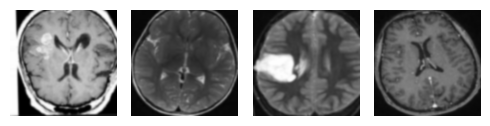

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5754 - loss: 0.9731 - val_accuracy: 0.5097 - val_loss: 0.6980
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7553 - loss: 0.4981 - val_accuracy: 0.6000 - val_loss: 0.6530
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7977 - loss: 0.4330 - val_accuracy: 0.6258 - val_loss: 0.6241
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8253 - loss: 0.3831 - val_accuracy: 0.7032 - val_loss: 0.5859
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8563 - loss: 0.3467 - val_accuracy: 0.7548 - val_loss: 0.5407
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8694 - loss: 0.3129 - val_accuracy: 0.8032 - val_loss: 0.4903
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8783 - loss: 0.2870 - val_accuracy: 0.8226 - val_loss: 0.4496
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8868 - loss: 0.2683 - val_accuracy: 0.8258 - val_loss:

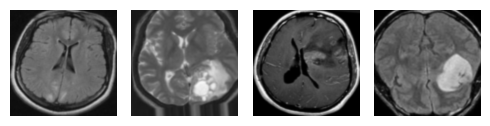

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6084 - loss: 0.8488 - val_accuracy: 0.5419 - val_loss: 0.6596
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7712 - loss: 0.4931 - val_accuracy: 0.7161 - val_loss: 0.6101
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7987 - loss: 0.4312 - val_accuracy: 0.7774 - val_loss: 0.5526
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8142 - loss: 0.3759 - val_accuracy: 0.7903 - val_loss: 0.5106
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8276 - loss: 0.3700 - val_accuracy: 0.7000 - val_loss: 0.5601
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8544 - loss: 0.3046 - val_accuracy: 0.7452 - val_loss: 0.5110
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8753 - loss: 0.2718 - val_accuracy: 0.8065 - val_loss: 0.3978
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9042 - loss: 0.2367 - val_accuracy: 0.8290 - val_loss:

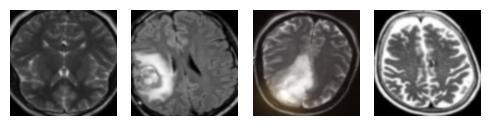

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5575 - loss: 0.9476 - val_accuracy: 0.5323 - val_loss: 0.6704
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7448 - loss: 0.5247 - val_accuracy: 0.7194 - val_loss: 0.6268
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7698 - loss: 0.4824 - val_accuracy: 0.6613 - val_loss: 0.6154
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8062 - loss: 0.4200 - val_accuracy: 0.7581 - val_loss: 0.5696
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8387 - loss: 0.3630 - val_accuracy: 0.8419 - val_loss: 0.5061
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8544 - loss: 0.3266 - val_accuracy: 0.8290 - val_loss: 0.4797
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8778 - loss: 0.2985 - val_accuracy: 0.8516 - val_loss: 0.4352
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8853 - loss: 0.2756 - val_accuracy: 0.8613 - val_loss:

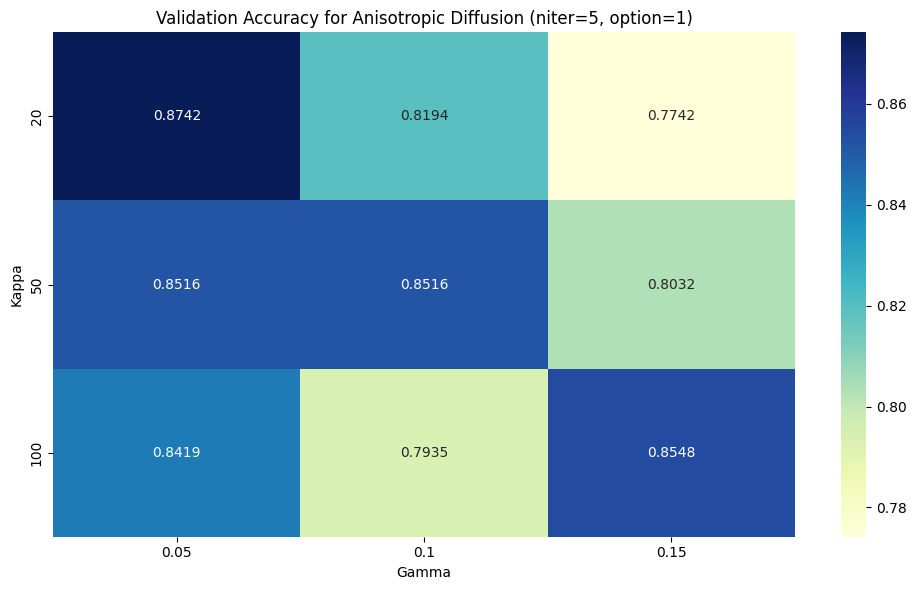


Grid Search Results:
Experiment: anisotropic_niter5_kappa20_gamma0.05, Val Accuracy: 0.8742, Time: 0:9:5.6
Experiment: anisotropic_niter10_kappa20_gamma0.05, Val Accuracy: 0.8161, Time: 0:9:24.2
Experiment: anisotropic_niter5_kappa50_gamma0.05, Val Accuracy: 0.8516, Time: 0:9:5.0
Experiment: anisotropic_niter10_kappa50_gamma0.05, Val Accuracy: 0.8258, Time: 0:9:5.3
Experiment: anisotropic_niter5_kappa100_gamma0.05, Val Accuracy: 0.8419, Time: 0:8:57.3
Experiment: anisotropic_niter10_kappa100_gamma0.05, Val Accuracy: 0.8000, Time: 0:9:33.9
Experiment: anisotropic_niter5_kappa20_gamma0.1, Val Accuracy: 0.8194, Time: 0:9:26.1
Experiment: anisotropic_niter10_kappa20_gamma0.1, Val Accuracy: 0.7968, Time: 0:9:5.3
Experiment: anisotropic_niter5_kappa50_gamma0.1, Val Accuracy: 0.8516, Time: 0:9:12.4
Experiment: anisotropic_niter10_kappa50_gamma0.1, Val Accuracy: 0.8645, Time: 0:9:1.8
Experiment: anisotropic_niter5_kappa100_gamma0.1, Val Accuracy: 0.7935, Time: 0:9:36.3
Experiment: anisotropic

<Figure size 640x480 with 0 Axes>

In [20]:
param_grid = {
    'niter': [5, 10],
    'kappa': [20, 50, 100],
    'gamma': [0.05, 0.1, 0.15]
}

best_val_accuracy = 0
best_params = None
results = []

for params in ParameterGrid(param_grid):
    niter = params['niter']
    kappa = params['kappa']
    gamma = params['gamma']

    experiment_name = f"anisotropic_niter{niter}_kappa{kappa}_gamma{gamma}"
    print(f"\nRunning experiment: {experiment_name}")

    model = build_model(IMG_SHAPE)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X, y = load_data(
        [original_augmented_yes, original_augmented_no],
        (IMG_WIDTH, IMG_HEIGHT),
        grayscale=False,
        contrast_enhancement=False,
        anisotropic_diffusion=True,
        smoothing=False,
        bilateral_filtering=False,
        aniso_niter=niter,
        aniso_kappa=kappa,
        aniso_gamma=gamma,
        aniso_option=1
    )

    plot_example_images(X, f"{experiment_name}_niter{niter}_kappa{kappa}_gamma{gamma}")

    # Split the data
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

    # Define file path for saving the model
    filepath = os.path.join(model_dir, f"{experiment_name}.keras")
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    # Train the model
    start_time = time.time()
    history = model.fit(
        x=X_train, y=y_train,
        batch_size=32,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[checkpoint],
        verbose=1
    )
    end_time = time.time()
    execution_time = end_time - start_time

    # Get the best validation accuracy from this run
    val_accuracy = max(history.history['val_accuracy'])
    print(f"{experiment_name} - Elapsed time: {hms_string(execution_time)} - Val Accuracy: {val_accuracy:.4f}")

    # Evaluate on test set
    test_metrics = evaluate(model, X_test, y_test, X_val, y_val)

    # Store results
    results.append({
        'experiment_name': experiment_name,
        'niter': niter,
        'kappa': kappa,
        'gamma': gamma,
        'val_accuracy': val_accuracy,
        'test_metrics': test_metrics,
        'execution_time': execution_time
    })

    # Update best parameters if this run is better
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params

# Find the best 'niter' value and create a heatmap for kappa vs. gamma
best_niter = best_params['niter']
kappas = param_grid['kappa']
gammas = param_grid['gamma']
val_accuracies = np.zeros((len(kappas), len(gammas)))

for result in results:
    if result['niter'] == best_niter:
        i = kappas.index(result['kappa'])
        j = gammas.index(result['gamma'])
        val_accuracies[i, j] = result['val_accuracy']

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=gammas, yticklabels=kappas, cmap="YlGnBu")
plt.title(f"Validation Accuracy for Anisotropic Diffusion (niter={best_niter}, option=1)")
plt.xlabel("Gamma")
plt.ylabel("Kappa")
plt.tight_layout()
plt.show()
plt.savefig(f"images/{experiment_name}_grid-search.png", dpi=300)

# Print grid search results
print("\nGrid Search Results:")
for result in results:
    print(f"Experiment: {result['experiment_name']}, Val Accuracy: {result['val_accuracy']:.4f}, "
          f"Time: {hms_string(result['execution_time'])}")

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Print test metrics for the best parameters
best_result = next(r for r in results if r['niter'] == best_params['niter'] and
                   r['kappa'] == best_params['kappa'] and
                   r['gamma'] == best_params['gamma'])
print(f"\nTest Metrics for Best Parameters ({best_result['experiment_name']}):")
for metric_name, metric_value in best_result['test_metrics'].items():
    print(f"{metric_name}: {metric_value:.4f}")

# Auditory Brain Implant Data Augmentation

In [15]:
implant_augmented_path = 'implant_augmented_data/'

implant_augmented_yes = implant_augmented_path + 'yes'
implant_augmented_no = implant_augmented_path + 'no'

augment_data_implant(original_augmented_yes, implant_augmented_yes, percentage=0.25)
augment_data_implant(original_augmented_no, implant_augmented_no, percentage=0.25)


experiment_name = "implant"
model = build_model(IMG_SHAPE)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X, y = load_data(
    [implant_augmented_yes, implant_augmented_no],
    (IMG_WIDTH, IMG_HEIGHT),
    grayscale=False,
    contrast_enhancement=False,
    anisotropic_diffusion=False,
    smoothing=False,
    bilateral_filtering=False
)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

# Static file path to ensure only the best model is saved
filepath = os.path.join(model_dir, f"{experiment_name}.keras")

# Save only the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

start_time = time.time()

# Train the model without checkpointing
model.fit(x=X_train, y=y_train, batch_size=32, epochs=EPOCHS, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint], verbose=1)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"{experiment_name} - Elapsed time: {hms_string(execution_time)}")

evaluate(model, X_test, y_test, X_val, y_val)

Processing 1085 images, augmenting 271


100%|██████████| 1085/1085 [00:02<00:00, 370.78it/s]


Processing 980 images, augmenting 245


100%|██████████| 980/980 [00:01<00:00, 504.07it/s]


No contours found in image
No contours found in image
No contours found in image
No contours found in image
No contours found in image
Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 490ms/step - accuracy: 0.5704 - loss: 1.0614 - val_accuracy: 0.6806 - val_loss: 0.6471
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 477ms/step - accuracy: 0.7285 - loss: 0.5165 - val_accuracy: 0.7355 - val_loss: 0.6174
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 465ms/step - accuracy: 0.7849 - loss: 0.4314 - val_accuracy: 0.6258 - val_loss: 0.6173
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8379 - loss: 0.3735 - val_accuracy: 0.6032 - val_loss: 0.6180
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8686 - loss: 0.3278 - val_accuracy: 0.7065 - val_loss: 0.5389
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.8824 - loss: 0.2979 - val_accuracy: 0.6613 - val_loss: 0.5618
Epoch 7/1

{'test_loss': 0.9413323998451233,
 'test_accuracy': 0.6064516305923462,
 'val_f1_score': 0.42290748898678415,
 'test_f1_score': 0.4351851851851852}